# Importing the required Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow import expand_dims
from tensorflow.math import reduce_sum
from tensorflow.nn import tanh, softmax
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Input, LSTM, Bidirectional, Layer,Dot, Multiply, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.dtypes import uint8, float32
import pickle

In [ ]:
!pip install -q keras-tcn
from tcn import TCN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.random import set_seed
set_seed(5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Preprocessing

In [ ]:
true = pd.read_csv('/content/drive/MyDrive/data_set_1/ISOT Fake News Dataset/True.csv')
fake = pd.read_csv('/content/drive/MyDrive/data_set_1/ISOT Fake News Dataset/Fake.csv')

In [ ]:
# add 1 for label for true and 0 fro fake
true["label"] = 1
fake['label'] = 0

In [ ]:
# Combine both dataframes and shuffle
input_data = pd.concat( [true,fake] )
input_data = input_data.sample(frac = 1)

In [ ]:
# remove website url and ip
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", x))
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"^(?!mailto:)(?:(?:http|https|ftp)://)(?:\\S+(?::\\S*)?@)?(?:(?:(?:[1-9]\\d?|1\\d\\d|2[01]\\d|22[0-3])(?:\\.(?:1?\\d{1,2}|2[0-4]\\d|25[0-5])){2}(?:\\.(?:[0-9]\\d?|1\\d\\d|2[0-4]\\d|25[0-4]))|(?:(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)(?:\\.(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)*(?:\\.(?:[a-z\\u00a1-\\uffff]{2,})))|localhost)(?::\\d{2,5})?(?:(/|\\?|#)[^\\s]*)?$", "", x))
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"^((25[0-5]|(2[0-4]|1[0-9]|[1-9]|)[0-9])(\.(?!$)|$)){4}$", "", x))

In [ ]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
stopwords=stopwords.words('english')
input_data['text'] = input_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#STEMMING
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
porter = PorterStemmer()
# for word in input_data['text']:
#     print(porter.stem(word))
input_data['text'] = input_data['text'].apply(lambda x: ' '.join([porter.stem(y) for y in x.split()]))

Mapping Text to Vectors

In [ ]:
pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
# Tockenization
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding

In [ ]:
tokenizer = Tokenizer(num_words=9999999999)
tokenizer.fit_on_texts(input_data['text'])
sequences = tokenizer.texts_to_sequences(input_data['text'])
word_index = tokenizer.word_index

In [ ]:
len(sequences)

44898

In [ ]:
import tensorflow as tf
sequences=tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=100,
    dtype='int32',
    padding='post',
    truncating='pre',
    value=0.0
)

In [ ]:
sequences

array([[  998,  1036,  7539, ...,  1536, 82414,  9032],
       [  372,  5737,  1510, ...,   105,   103,  2893],
       [   44, 19827,    52, ...,   855,  1405,  4060],
       ...,
       [  204,  1387,    96, ...,    35,   448, 11350],
       [  493,    35,   644, ..., 43703,   110,  8701],
       [  215,   480, 15132, ...,    91,   103, 50595]], dtype=int32)

In [ ]:
GLOVE_DIR = "data"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, '/content/drive/MyDrive/data_set_1/ISOT Fake News Dataset/glove.6B.300d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=300)

Total 400000 word vectors in Glove.


# SPLITTING THE DATA


In [ ]:
data=sequences
label= input_data["label"]
x_train, x_test, y_train, y_test = train_test_split( data, label, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 35918 4490 4490
real & fake news in train,valt,test:
17150
2099
2168


# MODEL

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Project_Models/Processed_Data/'
path1 = '/content/drive/MyDrive/Colab Notebooks/Project_Models/'
x_train=pickle.load(open(path+'x_train.pkl', 'rb'))
y_train=pickle.load(open(path+'y_train.pkl', 'rb'))
y_test=pickle.load(open(path+'y_test.pkl', 'rb'))
x_test=pickle.load(open(path+'x_test.pkl', 'rb'))
x_val=pickle.load(open(path+'x_val.pkl', 'rb'))
y_val=pickle.load(open(path+'y_val.pkl', 'rb'))
embedding_layer = pickle.load(open(path1+'i100embedding_layer.pkl', 'rb'))

ModuleNotFoundError: ignored

In [ ]:
class Attention(Layer):

    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()

    def build(self, input_shape):

        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(Attention,self).build(input_shape)

    def call(self, x):

        w = expand_dims(self.W, 0)
        e = tanh(Dot(axes = [2, 1])([x,w])+self.b)
        a = softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return reduce_sum(output, axis=1)

In [ ]:
i = Input([100], dtype=uint8)
x = embedding_layer(i)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPool1D()(x)
# x = LSTM(32, activation='linear')(x)
# x = (Bidirectional(LSTM(32, activation='linear')(x))
# prediction = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=[i], outputs=prediction)

# x = Embedding(10000 + 1,
#                             300,
#                             # weights=[embedding_matrix],
#                             input_length=300)(i)

max_len = 200
rnn_cell_size = 128
vocab_size = 250

x = Bidirectional(LSTM(rnn_cell_size,
                        return_sequences=True), name="bi_lstm_0")(x)
x= Dropout(0.30)(x)
x = Attention(return_sequences=True)(x)
# x = LSTM(128, activation='linear', return_sequences=True)(x)
x = TCN(return_sequences=False)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=i , outputs=output)
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# lstm, forward_h, forward_c, backward_h, backward_c =Bidirectional \
#     (LSTM(rnn_cell_size,
#       return_sequences=True))(x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          38994900  
                                                                 
 bi_lstm_0 (Bidirectional)   (None, 100, 256)          439296    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 attention (Attention)       (None, 100, 256)          356       
                                                                 
 tcn (TCN)                   (None, 64)                201536    
                                                                 
 dense (Dense)               (None, 1)                 65    

In [ ]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    acc = logs.get('accuracy')
    val_acc = logs.get('val_accuracy')
    if (epoch % 5 == 0) and (epoch != 0):
      model_name = f'BLSTM-ATT-TCN_e{epoch}'  # add model name (name_) as required
      model_path = '/content/drive/MyDrive/Colab Notebooks/Project_Models/BLSTM_ATT_TCN_Models'  # add model path as required
      self.model.save(os.path.join(model_path, model_name))

callback = myCallback()

callbacks=[callback]

In [ ]:
BATCH_SIZE = 64
EPOCHS = 40
TRAINING_STEPS = len(x_train) //  BATCH_SIZE
VALIDATION_STEPS = len(x_val) // BATCH_SIZE

history = model.fit(x_train,y_train,
                    steps_per_epoch= TRAINING_STEPS,
                    validation_data=[x_val,y_val],
                    validation_steps=VALIDATION_STEPS,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose='auto')

Epoch 1/40
561/561 [==============================] - 715s 1s/step - loss: 0.2409 - accuracy: 0.8921 - val_loss: 0.1801 - val_accuracy: 0.9258
Epoch 2/40
561/561 [==============================] - 710s 1s/step - loss: 0.1338 - accuracy: 0.9493 - val_loss: 0.1501 - val_accuracy: 0.9428
Epoch 3/40
561/561 [==============================] - 711s 1s/step - loss: 0.1046 - accuracy: 0.9592 - val_loss: 0.1184 - val_accuracy: 0.9568
Epoch 4/40
561/561 [==============================] - 710s 1s/step - loss: 0.0873 - accuracy: 0.9662 - val_loss: 0.0999 - val_accuracy: 0.9648
Epoch 5/40
561/561 [==============================] - 712s 1s/step - loss: 0.0710 - accuracy: 0.9740 - val_loss: 0.1169 - val_accuracy: 0.9648
Epoch 6/40
561/561 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9801

561/561 [==============================] - 733s 1s/step - loss: 0.0563 - accuracy: 0.9801 - val_loss: 0.1034 - val_accuracy: 0.9661
Epoch 7/40
561/561 [==============================] - 726s 1s/step - loss: 0.0417 - accuracy: 0.9855 - val_loss: 0.1269 - val_accuracy: 0.9633
Epoch 8/40
561/561 [==============================] - 727s 1s/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.1663 - val_accuracy: 0.9657
Epoch 9/40
561/561 [==============================] - 727s 1s/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.1379 - val_accuracy: 0.9697
Epoch 10/40
561/561 [==============================] - 728s 1s/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.1415 - val_accuracy: 0.9759
Epoch 11/40
561/561 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9947

561/561 [==============================] - 750s 1s/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0.1193 - val_accuracy: 0.9746
Epoch 12/40
561/561 [==============================] - 733s 1s/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.1487 - val_accuracy: 0.9737
Epoch 13/40
561/561 [==============================] - 728s 1s/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.1236 - val_accuracy: 0.9755
Epoch 14/40
561/561 [==============================] - 728s 1s/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.1401 - val_accuracy: 0.9759
Epoch 15/40
561/561 [==============================] - 730s 1s/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.1597 - val_accuracy: 0.9735
Epoch 16/40
561/561 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9969

561/561 [==============================] - 754s 1s/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.1406 - val_accuracy: 0.9744
Epoch 17/40
561/561 [==============================] - 736s 1s/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.1568 - val_accuracy: 0.9771
Epoch 18/40
561/561 [==============================] - 732s 1s/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.1727 - val_accuracy: 0.9733
Epoch 19/40
561/561 [==============================] - 734s 1s/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.1484 - val_accuracy: 0.9715
Epoch 20/40
561/561 [==============================] - 747s 1s/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.1715 - val_accuracy: 0.9728
Epoch 21/40
561/561 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

561/561 [==============================] - 777s 1s/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.2229 - val_accuracy: 0.9717
Epoch 22/40
561/561 [==============================] - 759s 1s/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.1483 - val_accuracy: 0.9717
Epoch 23/40
561/561 [==============================] - 763s 1s/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.1900 - val_accuracy: 0.9759
Epoch 24/40
561/561 [==============================] - 759s 1s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.2300 - val_accuracy: 0.9715
Epoch 25/40
561/561 [==============================] - 759s 1s/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.1512 - val_accuracy: 0.9757
Epoch 26/40
561/561 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9982

561/561 [==============================] - 773s 1s/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.2134 - val_accuracy: 0.9755
Epoch 27/40
561/561 [==============================] - 758s 1s/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.1320 - val_accuracy: 0.9766
Epoch 28/40
561/561 [==============================] - 743s 1s/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.1614 - val_accuracy: 0.9766
Epoch 29/40
561/561 [==============================] - 737s 1s/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.1851 - val_accuracy: 0.9731
Epoch 30/40
561/561 [==============================] - 747s 1s/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.2358 - val_accuracy: 0.9715
Epoch 31/40
561/561 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990

561/561 [==============================] - 776s 1s/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.1703 - val_accuracy: 0.9753
Epoch 32/40
561/561 [==============================] - 754s 1s/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.1621 - val_accuracy: 0.9737
Epoch 33/40
561/561 [==============================] - 748s 1s/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.2746 - val_accuracy: 0.9608
Epoch 34/40
561/561 [==============================] - 749s 1s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.1839 - val_accuracy: 0.9715
Epoch 35/40
561/561 [==============================] - 748s 1s/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.1665 - val_accuracy: 0.9768
Epoch 36/40
561/561 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9990

561/561 [==============================] - 780s 1s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.1797 - val_accuracy: 0.9811
Epoch 37/40
561/561 [==============================] - 761s 1s/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.2824 - val_accuracy: 0.9693
Epoch 38/40
561/561 [==============================] - 753s 1s/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.2011 - val_accuracy: 0.9777
Epoch 39/40
561/561 [==============================] - 764s 1s/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.1977 - val_accuracy: 0.9775
Epoch 40/40
241/561 [===========>..................] - ETA: 6:58 - loss: 0.0052 - accuracy: 0.9986

561/561 [==============================] - 334s 593ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.1694 - val_accuracy: 0.9739


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Project_Models/Processed_Data/'
pickle.dump(history, open(path+'history_BLSTM_ATT_TCN.pkl', 'wb'))

# Metrics and Graphs


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


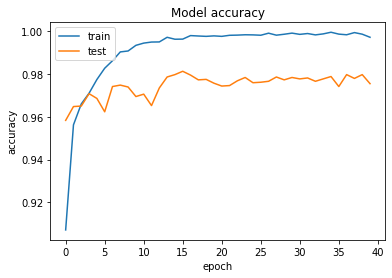

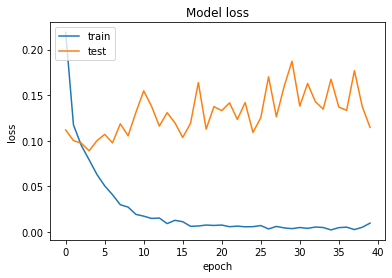

In [ ]:
# Training History
print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['val_accuracy'], )
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
model=load_model('/content/drive/MyDrive/Colab Notebooks/Project_Models/BLSTM_ATT_TCN_Models/BLSTM-ATT-TCN_e35')

In [ ]:
y_pred=model.predict(x_test)
y_pred = np.squeeze(y_pred)
y_pred

141/141 [==============================] - 28s 184ms/step


array([0.000000e+00, 1.000000e+00, 1.000000e+00, ..., 1.000000e+00,
       9.858979e-13, 0.000000e+00], dtype=float32)

In [ ]:
p = lambda t : 1 if t>=0.5 else 0
y_pred=np.vectorize(p)(y_pred)

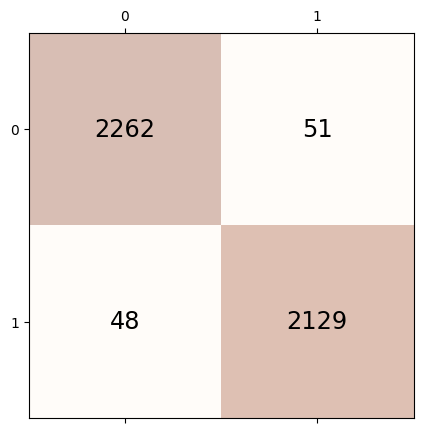

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Accuracy: 0.978
Precision: 0.977
Recall: 0.978
F1 Score: 0.977


In [ ]:
model.evaluate(x_test, y_test, verbose = 0)

[0.18193146586418152, 0.9779509902000427]

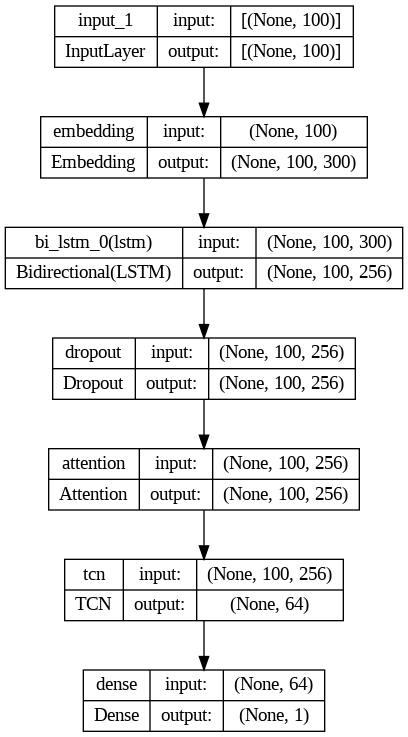

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
accuracy=[]
val_accuracy=[]
loss=[]
val_loss=[]

In [ ]:
final=['history_CNN_LSTM.pkl', 'history_CNN_BLSTM_ATT.pkl', 'history_BLSTM_ATT_TCN.pkl']

In [ ]:
from nltk.tag.hunpos import find_binary
for x in final:
              history=pickle.load(open(path1+x, 'rb'))
              accuracy.append(history.history['accuracy'])
              val_accuracy.append(history.history['val_accuracy'])
              loss.append(history.history['loss'])
              val_loss.append(history.history['val_loss'])

FileNotFoundError: ignored

In [ ]:
print (*accuracy)

[0.892145574092865, 0.9493111371994019, 0.9592183828353882, 0.9661617279052734, 0.9740106463432312, 0.9801306128501892, 0.9855096340179443, 0.9878697991371155, 0.991190493106842, 0.9936055541038513, 0.9947033524513245, 0.9953070878982544, 0.9961578845977783, 0.9967890381813049, 0.9964872002601624, 0.9968714118003845, 0.9971458315849304, 0.9971458315849304, 0.9970635175704956, 0.9976123571395874, 0.9979691505432129, 0.9981063604354858, 0.9982710480690002, 0.9984082579612732, 0.998161256313324, 0.9981886744499207, 0.997694730758667, 0.998819887638092, 0.9986826777458191, 0.9987101554870605, 0.9990119934082031, 0.9984631538391113, 0.9986826777458191, 0.9982984662055969, 0.9988473653793335, 0.9989845752716064, 0.9985729455947876, 0.9983259439468384, 0.9989022612571716, 0.9985931515693665] [0.7924693822860718, 0.8807563781738281, 0.9099292159080505, 0.9228003621101379, 0.9371809363365173, 0.9462100267410278, 0.9535375237464905, 0.9583127498626709, 0.9648444056510925, 0.9694000482559204, 0.9

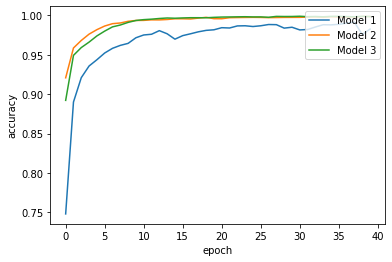

<Figure size 432x288 with 0 Axes>

In [ ]:
for x in accuracy:
                  plt.plot(x)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Model 1', 'Model 2','Model 3'], loc='lower right')
f = plt.figure()
plt.show()

<ipython-input-35-4518aa15624b>:5: MatplotlibDeprecationWarning: Unrecognized location 'lower rightt'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['Model1', 'Model2','Model3','Model4'], loc='lower rightt')


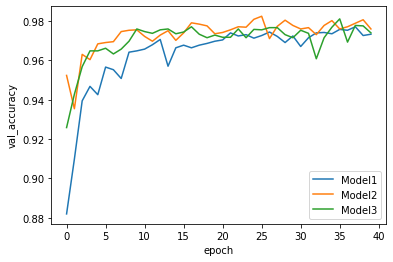

In [ ]:
for x in val_accuracy:
                  plt.plot(x)
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['Model1', 'Model2','Model3','Model4'], loc='lower rightt')
plt.show()

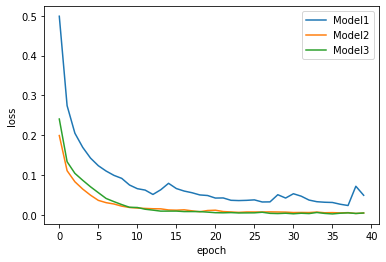

In [ ]:
for x in loss:
                  plt.plot(x)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Model1', 'Model2','Model3','Model4'], loc='upper right')
plt.show()

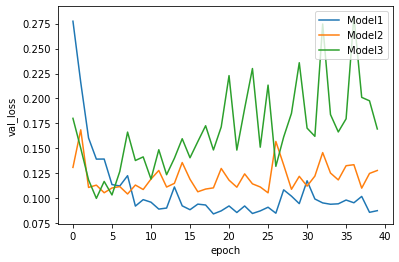

In [ ]:
for x in val_loss:
                  plt.plot(x)
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Model1', 'Model2','Model3','Model4'], loc='upper right')
plt.show()